Comparando clasificadores. <br>

También implementado PCA y cross-validation.

En digits['images'] se encuentran las imágenes en matrices 8x8.
En digits['target'] se encuentran las etiquetas para cada uno de los ejemplos.
En digits['data'] se encuentra la información a entrenar. Tamaño: (1797, 64)
Ejemplo [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.] 



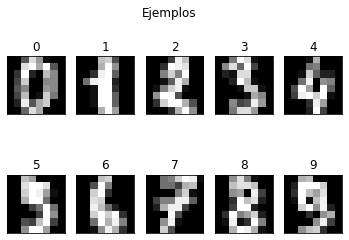

In [2]:
#Cargar dataset (Digits)
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np

digits = datasets.load_digits()

print("En digits['images'] se encuentran las imágenes en matrices 8x8.")
print("En digits['target'] se encuentran las etiquetas para cada uno de los ejemplos.")
print(f"En digits['data'] se encuentra la información a entrenar. Tamaño: {digits['data'].shape}")
print("Ejemplo",digits["data"][0],"\n")

f,axes=plt.subplots(2,5)
f.suptitle("Ejemplos")
for num,ax in enumerate(axes.flatten()):
    ax.imshow(digits["images"][num],cmap='gray')
    ax.set_title(digits["target"][num])
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)



In [12]:
from sklearn.datasets import fetch_openml

#Imágenes 28x28 del MNIST de Yann Lecun
MNIST={}
MNIST["data"], MNIST["target"] = fetch_openml('mnist_784', return_X_y=True)

image_shape=(28,28)

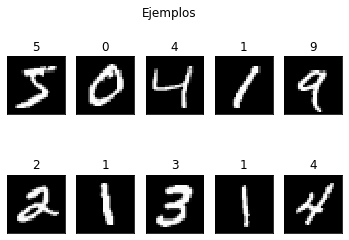

In [4]:

f,axes=plt.subplots(2,5)
f.suptitle("Ejemplos")
for num,ax in enumerate(axes.flatten()):
    ax.imshow(MNIST["data"][num].reshape(image_shape),cmap='gray')
    ax.set_title(MNIST["target"][num])
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

Balance de clases dentro del total de muestras


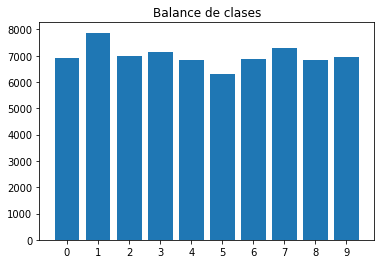

In [11]:
#Clases
plt.figure()
class_counts=np.unique(MNIST["target"], return_counts = True)
plt.bar(class_counts[0],class_counts[1])
plt.title("Balance de clases")
print("Balance de clases dentro del total de muestras")

Set de entrenamiento con el 75% de muestras: (3750, 784)
Balance de clases dentro del set de entrenamiento


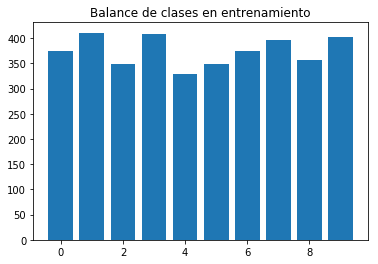

In [7]:
#Organizar train-test
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# #Para digits
# X=digits["data"]
# y=digits["target"]

#Para MNIST
#subsample para evitar quemar mi compu
X=MNIST["data"]
y=MNIST["target"].astype(int)
X,y=resample(X,y,n_samples=5000,replace=False,random_state=42)

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.25)
print(f"Set de entrenamiento con el 75% de muestras: {X_train.shape}")

plt.figure()
class_counts=np.unique(y_train, return_counts = True)
plt.bar(class_counts[0],class_counts[1])
plt.title("Balance de clases en entrenamiento")
print("Balance de clases dentro del set de entrenamiento")

Los primeros 84 componentes explican el 90.1% de la varianza de los dígitos.


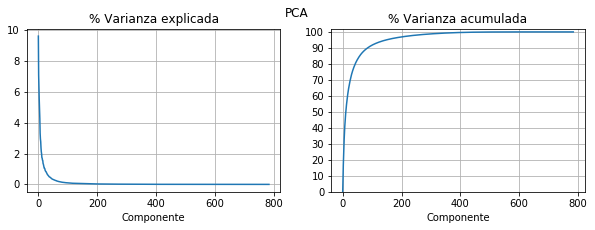

In [8]:
#PCA (tal vez buena idea hacer gridsearch para hallar número óptimo de parámetros)
from sklearn import decomposition
pca=decomposition.PCA()

train_size=X_train.shape
X_full=np.vstack([X_train,X_test])
y_full=np.hstack([y_train,y_test])
X_pca=pca.fit_transform(X_full)

f,ax=plt.subplots(1,2,figsize=(10,3))
ax[0].plot(100*pca.explained_variance_ratio_)
f.suptitle("PCA")
ax[0].set_title("% Varianza explicada")
ax[0].set_xlabel("Componente")
ax[0].grid()

varianza_acumulada=np.cumsum(pca.explained_variance_ratio_)
ax[1].plot(100*np.concatenate([[0],varianza_acumulada]))
ax[1].set_title("% Varianza acumulada")
ax[1].set_xlabel("Componente")
ax[1].set_yticks(range(0,101,10))
ax[1].set_ylim(0,102)
ax[1].grid()

#Se busca el índice del PC desde desde el cual se ha explicado el 90% de la varianza
PCA_idx=np.argwhere(varianza_acumulada>0.90)[0][0]
X_pca=X_pca[:,:PCA_idx]

#recupera train-test
Xpca_train=X_pca[0:train_size[0],:]
Xpca_test=X_pca[train_size[0]:,:]

print(f"Los primeros {PCA_idx} componentes explican el {100*varianza_acumulada[PCA_idx]:.1f}% de la varianza de los dígitos.")

Separación de clases en los dos primeros componentes principales
Si únicamente se ven los dos primeros componentes, se confunden varios números


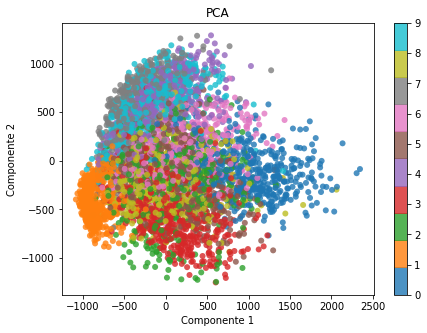

In [9]:
#Separación de componentes principales
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_full, edgecolor='none', alpha=0.8,cmap=plt.cm.get_cmap('tab10', 10))
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar()
plt.title("PCA")
print("Separación de clases en los dos primeros componentes principales")
print("Si únicamente se ven los dos primeros componentes, se confunden varios números")

Mejores parámetros: {'logreg__C': 0.01, 'poly__degree': 1} con accuracy_score 86.21


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,13.856577,6.470239,0.021002,0.000003,0.01,1,"{'logreg__C': 0.01, 'poly__degree': 1}",0.8624,0.8504,0.8736,0.862133,0.009473,1
1,8.652955,2.735933,0.021000,0.000815,1,1,"{'logreg__C': 1, 'poly__degree': 1}",0.8552,0.8504,0.8712,0.858933,0.008892,2


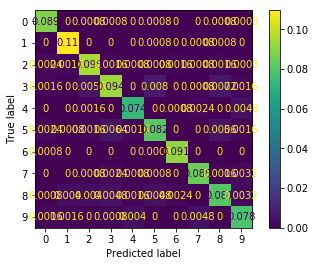

In [10]:
#Regresión logística sin PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd

poly=PolynomialFeatures(include_bias=False)
logreg=LogisticRegression(random_state=42,max_iter=10000)
pipe=Pipeline(steps=[
        ("poly",poly),
        ("logreg",logreg)
])

param_grid = [{
    'poly__degree': [2], #no pruebo con poly para no quemar mi compu
    'logreg__C': [0.01,1],
}]


search_lr=GridSearchCV(pipe,param_grid=param_grid,cv=3)
search_lr.fit(X_train,y_train)

pd.DataFrame(search_lr.cv_results_).sort_values(by="rank_test_score").head()

Matriz de confusión para Regresión logística
Mejores parámetros: {'logreg__C': 0.01, 'poly__degree': 1} con accuracy_score 93.57


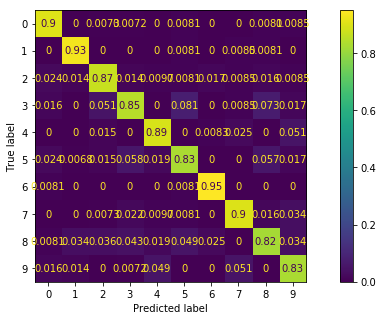

In [32]:
plt.figure(figsize=(12,5))
ax=plt.axes()
metrics.plot_confusion_matrix(search_lr,X_test,y_test,normalize="pred",ax=ax)

print("Matriz de confusión para Regresión logística")
print(f"Mejores parámetros: {search_lr.best_params_} con accuracy_score {100*search_lr_pca.best_score_:.2f}")

Total de imágenes de prueba: 1250
Total de errores: 153


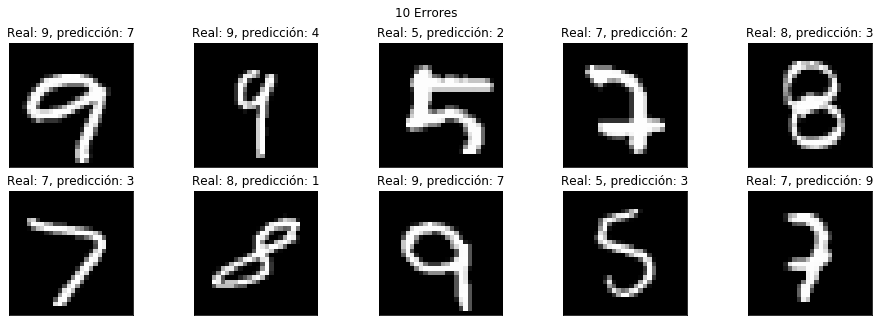

In [13]:
#Graficar las predicciones incorrectas
y_pred=search_lr.predict(X_test)

errores=np.where(y_pred!=y_test)[0]
errores_a_mostrar=errores[:10].reshape(2,5)

f,axes=plt.subplots(errores_a_mostrar.shape[0],errores_a_mostrar.shape[1],figsize=(16,5))
f.suptitle("10 Errores")
for num,ax in zip(errores_a_mostrar.flatten(),axes.flatten()):
    ax.imshow(X_test[num].reshape(28,28),cmap='gray')
    ax.set_title(f"Real: {y_test[num]}, predicción: {y_pred[num]}")
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

print(f"Total de imágenes de prueba: {len(y_test)}")
print(f"Total de errores: {len(errores)}")

Mejores parámetros: {'logreg__C': 0.01, 'poly__degree': 2} con accuracy_score 93.57


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,2.489327,0.117989,0.049335,0.000470,0.01,2,"{'logreg__C': 0.01, 'poly__degree': 2}",0.9384,0.9376,0.9312,0.935733,0.003222,1
3,2.620990,0.094725,0.051355,0.000503,0.001,2,"{'logreg__C': 0.001, 'poly__degree': 2}",0.9376,0.9368,0.9320,0.935467,0.002473,2
2,15.781480,3.985337,0.001650,0.000460,0.001,1,"{'logreg__C': 0.001, 'poly__degree': 1}",0.8368,0.8128,0.8512,0.833600,0.015839,3
0,20.232683,0.550261,0.001654,0.000491,0.01,1,"{'logreg__C': 0.01, 'poly__degree': 1}",0.8144,0.8096,0.8400,0.821333,0.013344,4


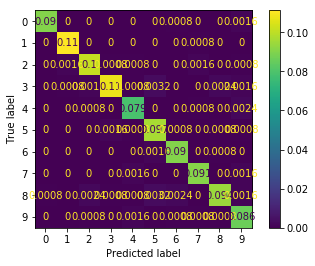

In [14]:
#Regresión logística con PCA
poly=PolynomialFeatures(include_bias=False)
logreg=LogisticRegression(random_state=42,max_iter=10000)
pipe=Pipeline(steps=[
        ("poly",poly),
        ("logreg",logreg)
])

param_grid = [{
    'poly__degree': [2,3],
    'logreg__C': [0.01,0.001],
}]

search_lr_pca=GridSearchCV(pipe,param_grid=param_grid,cv=3)
search_lr_pca.fit(Xpca_train,y_train)

pd.DataFrame(search_lr_pca.cv_results_).sort_values(by="rank_test_score").head()

Matriz de confusión para Regresión logística con PCA
Mejores parámetros: {'logreg__C': 0.01, 'poly__degree': 2} con accuracy_score 93.57


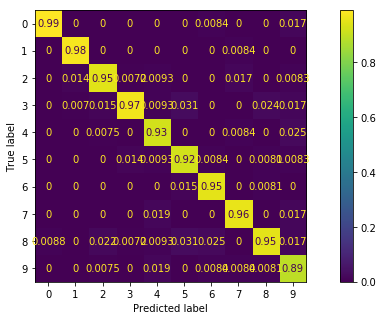

In [33]:
plt.figure(figsize=(12,5))
ax=plt.axes()
metrics.plot_confusion_matrix(search_lr_pca,Xpca_test,y_test,normalize="pred",ax=ax)

print("Matriz de confusión para Regresión logística con PCA")
print(f"Mejores parámetros: {search_lr_pca.best_params_} con accuracy_score {100*search_lr_pca.best_score_:.2f}")

Total de imágenes de prueba: 1250
Total de errores: 63


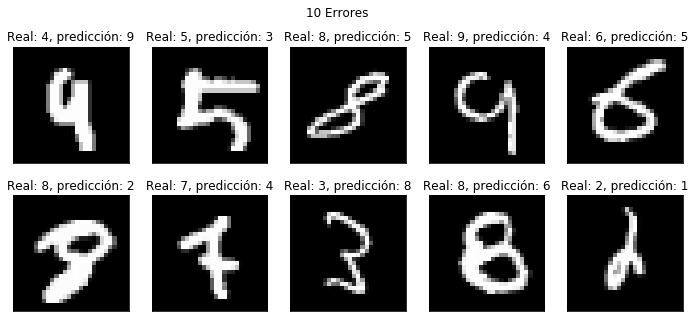

In [15]:
#Graficar las predicciones incorrectas
y_pred=search_lr_pca.predict(Xpca_test)

errores=np.where(y_pred!=y_test)[0]
errores_a_mostrar=errores[:10].reshape(2,5)

f,axes=plt.subplots(errores_a_mostrar.shape[0],errores_a_mostrar.shape[1],figsize=(12,5))
f.suptitle("10 Errores")
for num,ax in zip(errores_a_mostrar.flatten(),axes.flatten()):
    ax.imshow(X_test[num].reshape(28,28),cmap='gray')
    ax.set_title(f"Real: {y_test[num]}, predicción: {y_pred[num]}")
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

print(f"Total de imágenes de prueba: {len(y_test)}")
print(f"Total de errores: {len(errores)}")

In [37]:
#Ahora solo usando PCA
#KNN
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

#Regresión logística con PCA
poly=PolynomialFeatures(include_bias=False)
knn=KNeighborsClassifier()
pipe=Pipeline(steps=[
        ("poly",poly),
        ("knn",knn)
])

param_grid = [{
    'poly__degree': [1], #después de entrenar, dio mejor con 1
    'knn__n_neighbors': [1,2,5,10,15,20], #da mejor con valores menos de 20100],
    "knn__weights":["uniform","distance"]
}]

search_knn_pca=GridSearchCV(pipe,param_grid=param_grid,cv=3)
search_knn_pca.fit(Xpca_train,y_train)

pd.DataFrame(search_knn_pca.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,0.040347,0.000489,0.423345,0.002631,5,distance,1,"{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.9160,0.9304,0.9120,0.919467,0.007902,1
4,0.041679,0.000480,0.449321,0.000481,5,uniform,1,"{'knn__n_neighbors': 5, 'knn__weights': 'unifo...",0.9120,0.9280,0.9072,0.915733,0.008892,2
0,0.047353,0.005790,0.413646,0.002084,1,uniform,1,"{'knn__n_neighbors': 1, 'knn__weights': 'unifo...",0.9128,0.9184,0.9152,0.915467,0.002294,3
1,0.048998,0.006375,0.375335,0.005438,1,distance,1,"{'knn__n_neighbors': 1, 'knn__weights': 'dista...",0.9128,0.9184,0.9152,0.915467,0.002294,3
3,0.040379,0.000438,0.397310,0.003129,2,distance,1,"{'knn__n_neighbors': 2, 'knn__weights': 'dista...",0.9128,0.9184,0.9152,0.915467,0.002294,3


Matriz de confusión para Regresión logística con PCA
Mejores parámetros: {'knn__n_neighbors': 5, 'knn__weights': 'distance', 'poly__degree': 1} con accuracy_score 91.95


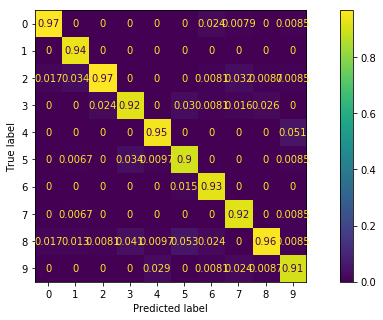

In [34]:
plt.figure(figsize=(12,5))
ax=plt.axes()
metrics.plot_confusion_matrix(search_knn_pca,Xpca_test,y_test,normalize="pred",ax=ax)

print("Matriz de confusión para Regresión logística con PCA")
print(f"Mejores parámetros: {search_knn_pca.best_params_} con accuracy_score {100*search_knn_pca.best_score_:.2f}")